
# Regression Example
The example below uses a [marketing](https://scikit-learn.org/stable/datasets/toy_dataset.html) dataset,
in order to illustrate a regression activity.

## Workflow
1. Preparation
    1. Load the dataset from a `.csv` file and show a short description
    1. Data preparation, according to background information
    1. Set the __target__ variable, according to background information
    1. Show the two dimensional scatter plots for all the predicting variables with respect to the target
    1. Split the data into *predicting variables* `X` and *target* `y`
        1. here we set the `random_state` variable to make the experiment *repeatable* 
1. First experiment: compute the regression on a single predicting variable
    1. Consider a reduced dataset containing the chosen variable and the target
    1. Fit the `LinearRegression` estimator on the training set
    1. Show the statistical significance of the fitted model
    1. Predict the target for the test set using the *fitted* estimator
    1. Compute the regression coefficients and the quality measures: *Root Mean Squared Error (RMSE)* and *coefficient of determination (r2)*
1. Second experiment: compute the regression considering all the predicting variables
    1. Repeat the steps from 2.2 to 2.5
1. Third experiment: use the `DecisionTreeRegressor` with the entire dataset
    1. Fit the tree using the default hyperparameters, in order to find the 
    maximum depth of the unconstrained tree
    1. Use *cross-validation* to find the optimal *maximum depth* of the tree
    1. Fit the tree with the optmal `max_depth`
    1. Predict and show the *root mean squared error*
1. Fourth experiment: use the `RandomForestRegressor`
    1. Repeat steps from 4.2 to 4.4 (for simplicity, we use the maximum `max_depth` found in 4.1)


In [268]:
# Code source: Claudio Sartori
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-v0_8")

random_state = (
    94922767  # this will be used to guarantee the repeatability of the experiment
)

## Load the dataset from a `.csv` file and show a short description

In [269]:
df = pd.read_csv("regression_example.csv")
df.head()

,idx,F0,F1,F2,F3,F4,F5,F6,F7,response
0,0,1.509081,-1.049118,1.978885,1.060733,NaN,0.824655,0.819409,-1.157708,214.593802
1,1,0.644764,0.007172,0.004493,4.168748,-0.622817,1.855366,-0.540468,1.141118,151.951717
2,2,0.890241,1.080162,0.168031,0.002733,0.522478,0.407804,1.629592,-1.102599,117.280863
3,3,-0.212410,-1.034267,1.843441,4.486992,-0.610050,0.734101,-0.142660,-0.172119,229.358473
4,4,-0.827402,-2.048496,-0.066242,1.361695,1.268456,-1.084906,1.986556,0.425511,230.153189


## Data Exploration and preparation

##### Show a short description of the columns

In [270]:
df.describe()

,idx,F0,F1,F2,F3,F4,F5,F6,F7,response
count,843.000000,802.000000,807.000000,812.000000,8.020000e+02,805.000000,808.000000,806.000000,812.000000,813.000000
mean,421.000000,-0.037473,0.008466,-0.059965,9.616777e-01,-0.093113,0.034653,-0.019928,-0.034976,3.798356
std,243.497433,1.038115,0.973884,0.991280,1.286476e+00,1.050385,0.957238,0.997345,0.963010,114.189124
min,0.000000,-3.700229,-2.832440,-4.141473,2.007427e-08,-4.072767,-2.968219,-2.850505,-3.948627,-358.659591
25%,210.500000,-0.723630,-0.640017,-0.681924,8.725649e-02,-0.802553,-0.625219,-0.689671,-0.662887,-73.823652
50%,421.000000,-0.032953,0.005693,-0.050789,4.707895e-01,-0.090512,0.051123,-0.014592,-0.049392,-0.159154
75%,631.500000,0.629368,0.681480,0.587393,1.350123e+00,0.611545,0.689203,0.612939,0.614423,75.487094
max,842.000000,3.043062,2.945731,2.925432,9.200073e+00,3.024952,3.210373,2.861549,3.000174,422.794685


##### Show the number of rows with nulls

It is computed subtracting the number of rows in the dataset without nulls from the original number of rows

In [271]:
df.shape[0] - df.dropna().shape[0]

273

#### Drop data that are useless or not usable

In [272]:
df = df.dropna().iloc[:, 1:]

In [273]:
df.head()

,F0,F1,F2,F3,F4,F5,F6,F7,response
1,0.644764,0.007172,0.004493,4.168748,-0.622817,1.855366,-0.540468,1.141118,151.951717
2,0.890241,1.080162,0.168031,0.002733,0.522478,0.407804,1.629592,-1.102599,117.280863
3,-0.212410,-1.034267,1.843441,4.486992,-0.610050,0.734101,-0.142660,-0.172119,229.358473
4,-0.827402,-2.048496,-0.066242,1.361695,1.268456,-1.084906,1.986556,0.425511,230.153189
5,-0.635465,-1.112850,-0.330580,6.141348,1.914527,0.408895,-0.364722,-0.731382,-261.116572


## Choose the target and split the data into *predicting variables* `X` and *target* `y`

In [274]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, 0:8]
y = df.iloc[:, [8]]

print(X.shape)
print(y.shape)

(570, 8)
(570, 1)


## Show the two dimensional scatter plots for all the predicting variables with respect to the target

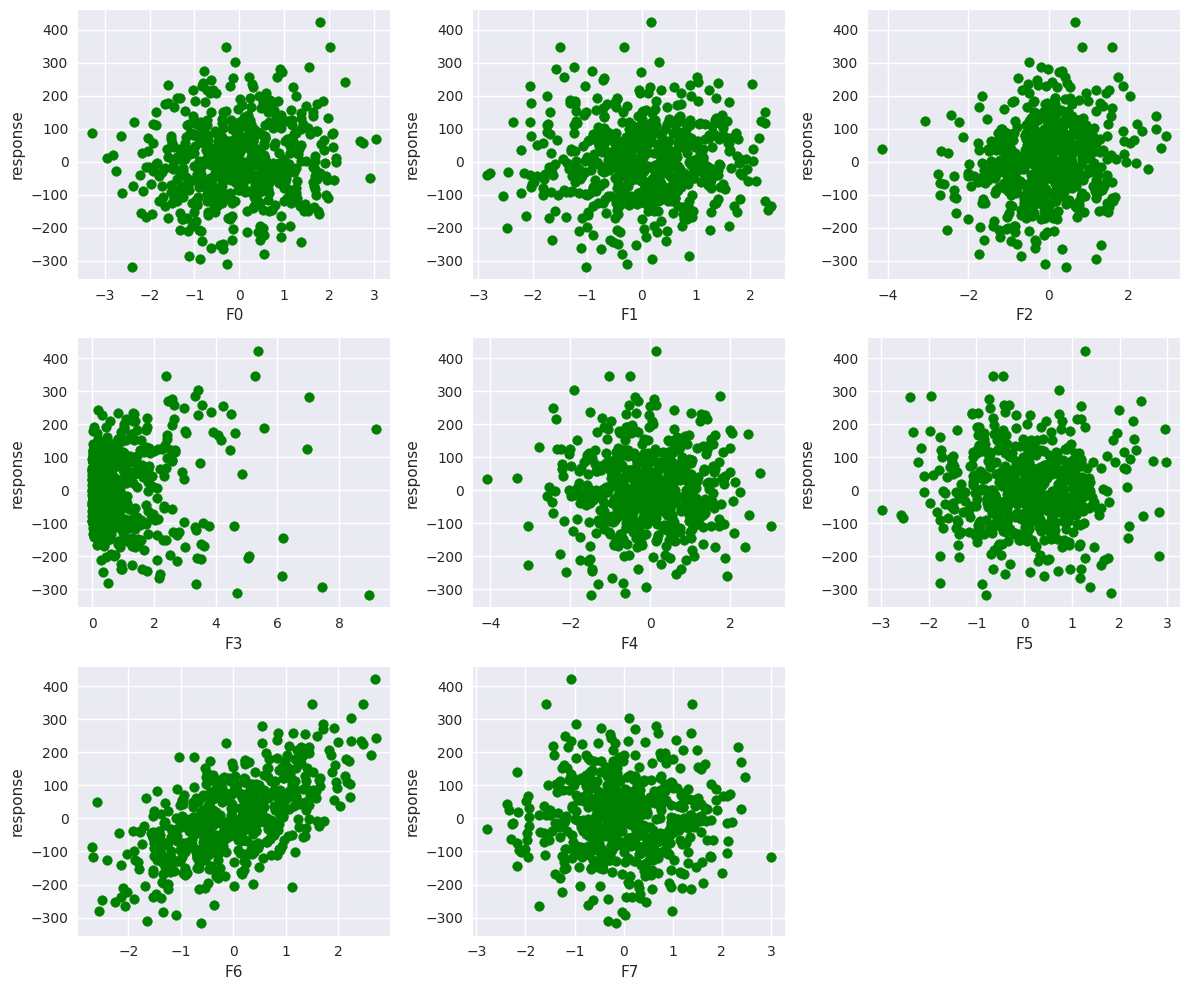

In [275]:
import matplotlib.pyplot as plt

ncols = 3
nrows = (X.columns.size // ncols) + 1
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 10))

for col, ax in zip(X.columns.tolist(), axs.ravel()):
    ax.scatter(X[col], y, color="green")
    ax.set(xlabel=col, ylabel=y.columns[0])

for i in range(X.shape[1], nrows * ncols):
    fig.delaxes(axs[i // ncols, i % ncols])
plt.tight_layout()
plt.show()

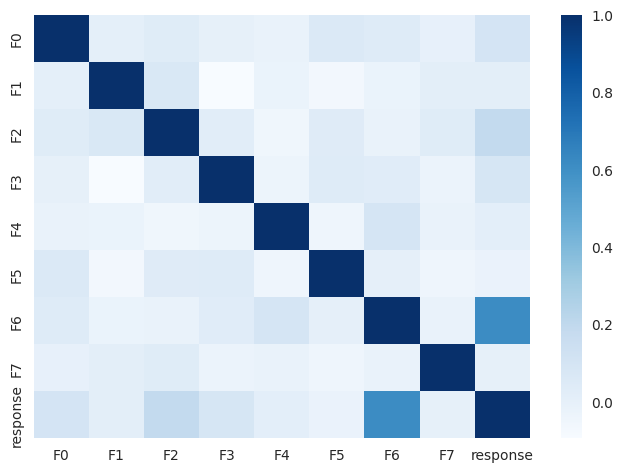

In [276]:
sns.heatmap(df.corr(), cmap="Blues")
plt.show()

## Split the data into *train* and *test* and show the sizes of the two parts
Here we set the `random_state` variable to make the experiment *repeatable*


In [277]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=random_state
)

print("X:\t", X.shape)
print("X_train:", X_train.shape)
print("X_test:\t", X_test.shape)
print("y:\t", y.shape)
print("y_train:", y_train.shape)
print("y_test:\t", y_test.shape)

X:	 (570, 8)
X_train: (399, 8)
X_test:	 (171, 8)
y:	 (570, 1)
y_train: (399, 1)
y_test:	 (171, 1)


## 2. First experiment - univariate linear regression
We choose the variable exhibiting the highest correlation with respect to the target

Consider a reduced dataset containing the chosen variable and the target

In [278]:
df.corr()

,F0,F1,F2,F3,F4,F5,F6,F7,response
F0,1.000000,0.007365,0.033151,0.000976,-0.017571,0.062904,0.044181,-0.001822,0.099714
F1,0.007365,1.000000,0.067446,-0.095361,-0.024113,-0.061430,-0.025050,0.017267,0.019469
F2,0.033151,0.067446,1.000000,0.028027,-0.049617,0.041146,-0.014830,0.035332,0.189681
F3,0.000976,-0.095361,0.028027,1.000000,-0.034434,0.044278,0.029957,-0.027759,0.085975
F4,-0.017571,-0.024113,-0.049617,-0.034434,1.000000,-0.042752,0.093363,-0.018163,0.012029
F5,0.062904,-0.061430,0.041146,0.044278,-0.042752,1.000000,0.005411,-0.040804,-0.021827
F6,0.044181,-0.025050,-0.014830,0.029957,0.093363,0.005411,1.000000,-0.014879,0.613199
F7,-0.001822,0.017267,0.035332,-0.027759,-0.018163,-0.040804,-0.014879,1.000000,0.002628
response,0.099714,0.019469,0.189681,0.085975,0.012029,-0.021827,0.613199,0.002628,1.000000


### Fit the `linear_model` estimator on the training set and predict the target for the test set using the *fitted* estimator

In [279]:
from sklearn import linear_model


regr = linear_model.LinearRegression()
regr.fit(np.array(X_train["F6"]).reshape(-1, 1), y_train)
y_pred_uni = regr.predict(np.array(X_test["F6"]).reshape(-1, 1))

#### Compute the quality measures

In [280]:
from numpy import sqrt

# Compute the RSS
rmse = mean_squared_error(y_test, y_pred_uni, squared=False)
print("Root Mean Square Error:", rmse)

# Compute the R-square index
rsquare = r2_score(y_test, y_pred_uni)
print("R-square:", rsquare)

Root Mean Square Error: 85.1217441119596
R-square: 0.33847681347897574


## Second experiment: compute the regression considering all the predicting variables

### Now we use the entire data in `X_train` and `X_test` for fitting and predicting

In [281]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred_multi = regr.predict(X_test)

### Fit, predict and show the results
Now we see the *regression coefficients* resulting from the fitting. 

In particular, *positive coefficients* indicate that the target *increases* with the variable, *negative coefficients* indicate a *decreasing* trend.

The absolute values of the coefficient cannot be considered directly a measure of importance, due to the possibly different orders of magnitude of the data in the different columns (observe above the outputs of `describe`).

In [282]:
pd.DataFrame({"Variable": X.columns, "Coefficients": regr.coef_[0]})

,Variable,Coefficients
0,F0,9.225329
1,F1,2.794846
2,F2,21.766171
3,F3,3.299594
4,F4,-5.532386
5,F5,-6.002884
6,F6,72.949625
7,F7,-2.675824


#### Compute the quality measures

In [283]:
# Compute the RSS
mse = mean_squared_error(y_test, y_pred_multi)
print("Root Mean Square Error:", sqrt(mse))

# Compute the R-square index
rsquare = r2_score(y_test, y_pred_multi)
print("R-square:", rsquare)

Root Mean Square Error: 81.1041677434571
R-square: 0.3994483175642217


## Decision Tree Multivariate Regresson

In [284]:
# Create Decision Tree regression object
from sklearn.tree import DecisionTreeRegressor

#### Fit the tree with default hyperparameters, and find the maximum depth of the unconstrained tree

In [285]:
regr = DecisionTreeRegressor()
regr.fit(X_train, y_train)

print("The maximum depth of the full Decision Tree Regressor is: ", regr.get_depth())

The maximum depth of the full Decision Tree Regressor is:  22


#### Find the optimal value of the hyperparameter `max_depth` with *cross-validation*
The optimization searches for the *maximum tree depth* guaranteing the smallest mean squared error
At the end, this operation returns also the *fitted best tree* `best_estimator_`

In [286]:
from sklearn.model_selection import GridSearchCV

In [287]:
gs = GridSearchCV(
    DecisionTreeRegressor(random_state=random_state),
    param_grid={"max_depth": [*range(1, 22)]},
)
gs.fit(X_train, y_train)
y_pred_dt = gs.predict(X_test)

print(gs.best_estimator_)

DecisionTreeRegressor(max_depth=2, random_state=94922767)


#### Show the tree

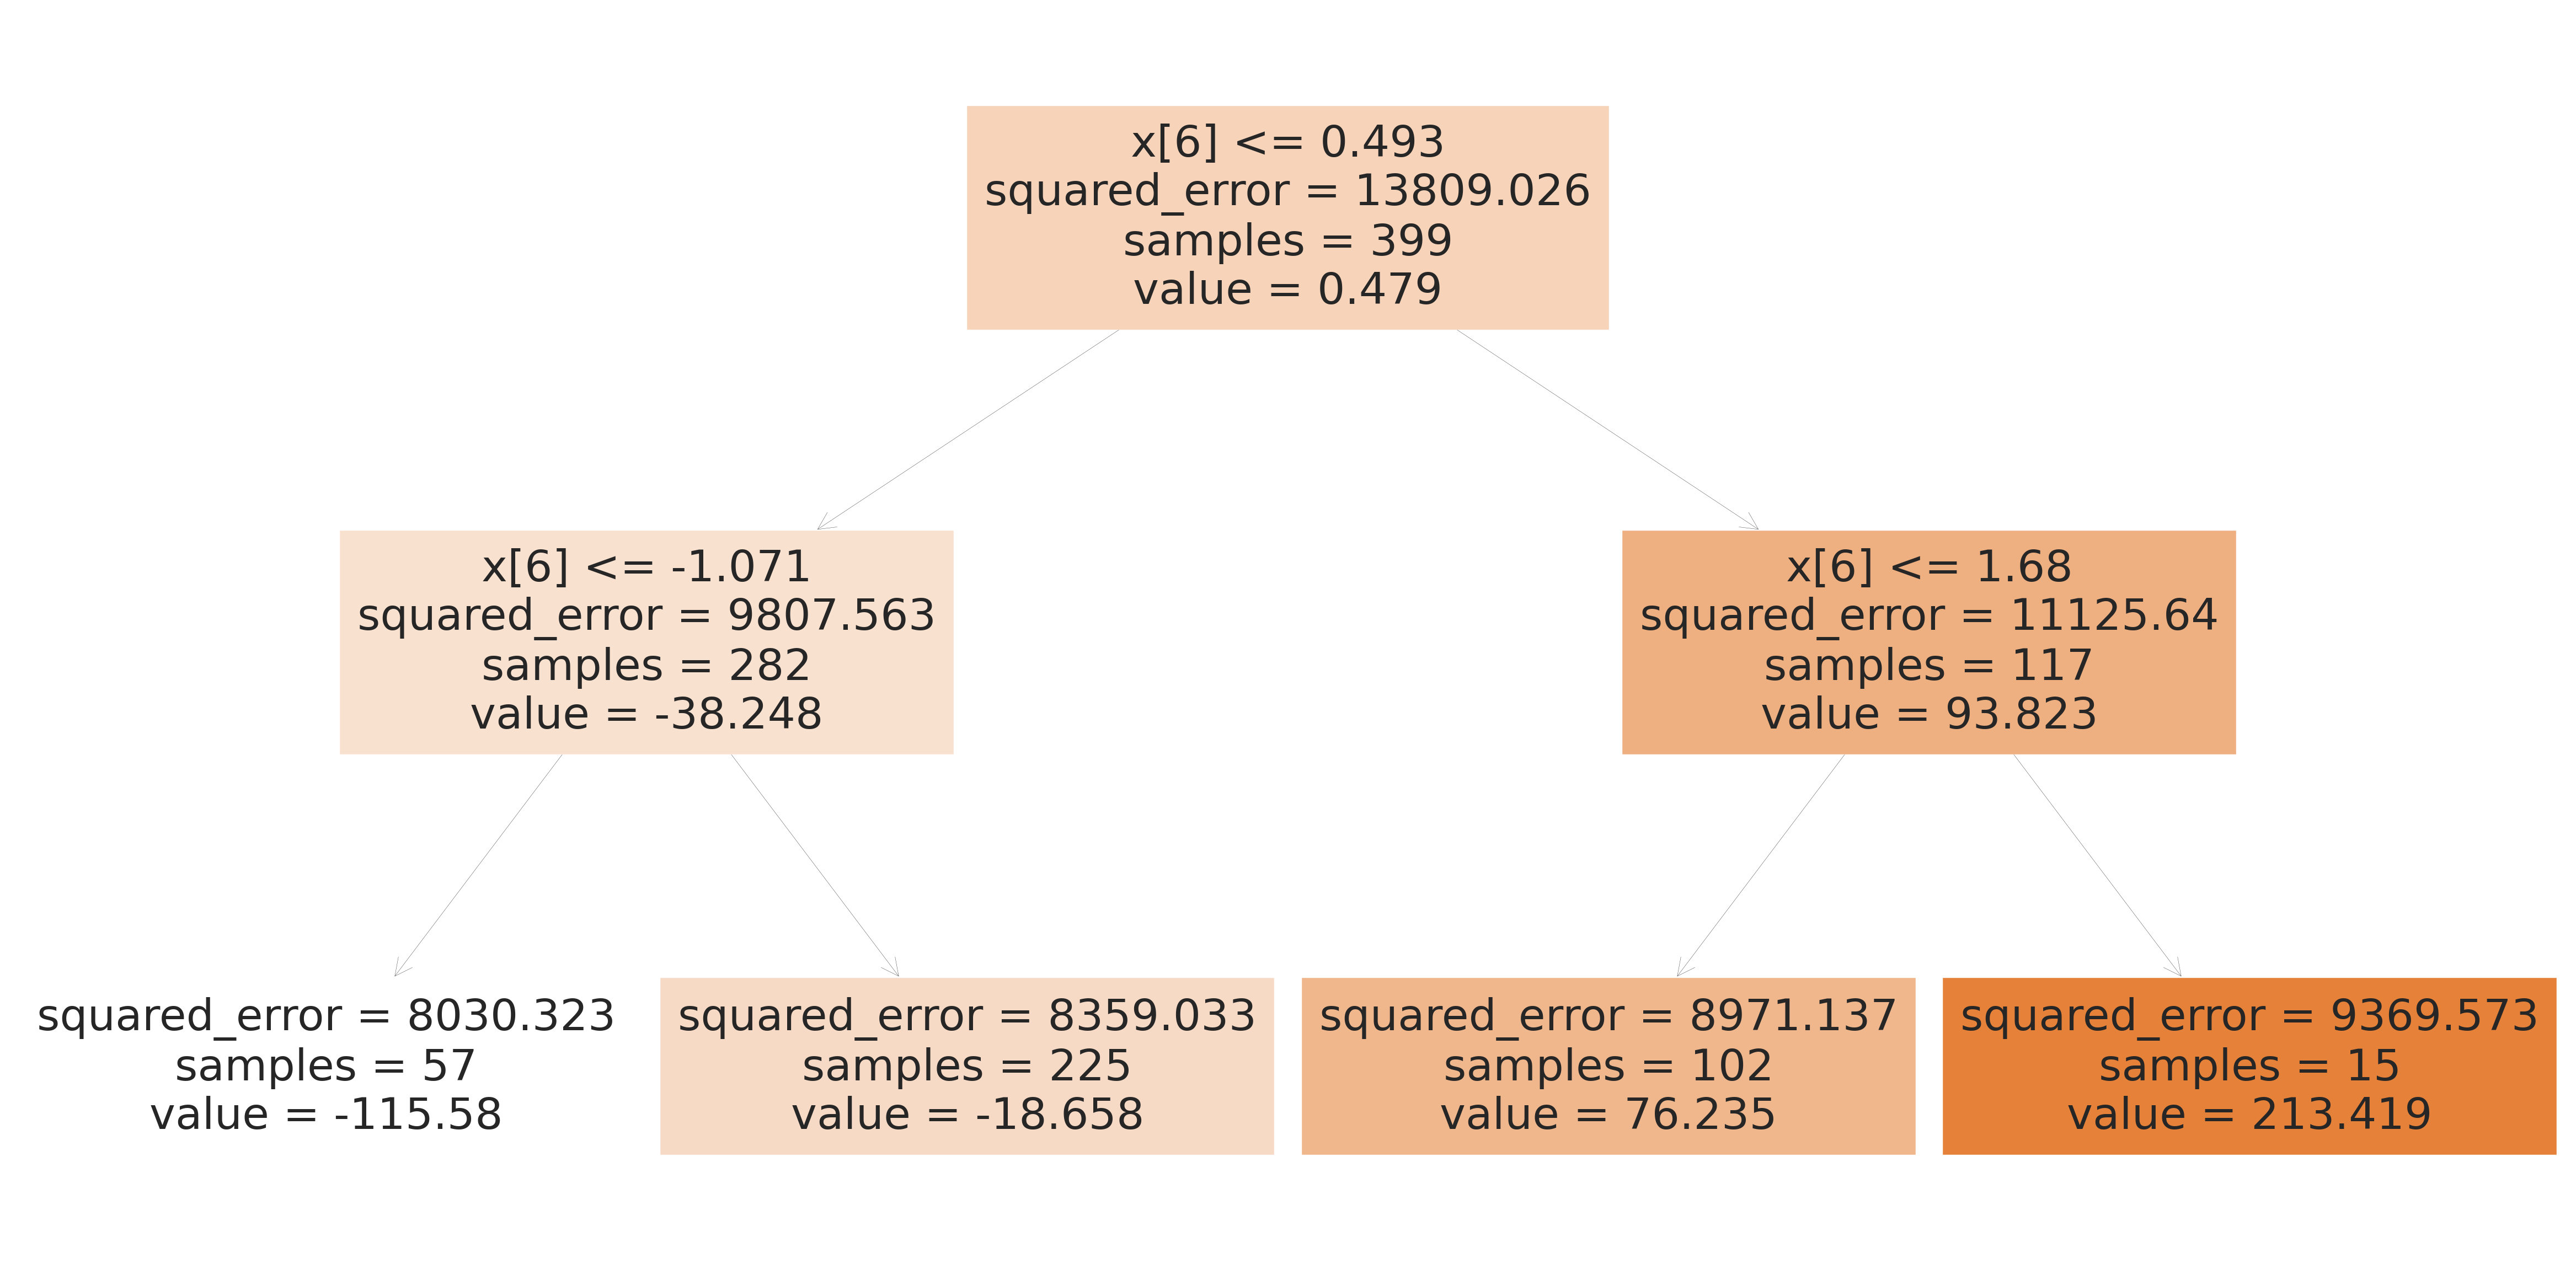

In [288]:
import sklearn.tree as tree

_, ax1 = plt.subplots(1, 1, figsize=(60, 30))
tree.plot_tree(gs.best_estimator_, filled=True, ax=ax1)
plt.show()

## Random Forest Multivariate Regresson

In [289]:
# Create Random Forest regression object
from sklearn.ensemble import RandomForestRegressor

In [290]:
gs = GridSearchCV(
    RandomForestRegressor(random_state=random_state),
    param_grid={"max_depth": [*range(1, 22)]},
)
gs.fit(X_train, np.ravel(y_train))

print(gs.best_estimator_)

RandomForestRegressor(max_depth=3, random_state=94922767)


In [291]:
y_pred_rf = gs.best_estimator_.predict(X_test)

# Compute the RSS
mse = mean_squared_error(y_test, y_pred_rf)
print("Root Mean Square Error:", sqrt(mse))

# Compute the R-square index
rsquare = r2_score(y_test, y_pred_rf)
print("R-square:", rsquare)

Root Mean Square Error: 84.70123424142166
R-square: 0.34499664977554156


### Plot the prediction of every model, compare it with the real test set, and print the metrics $R^2$ and RMSE 

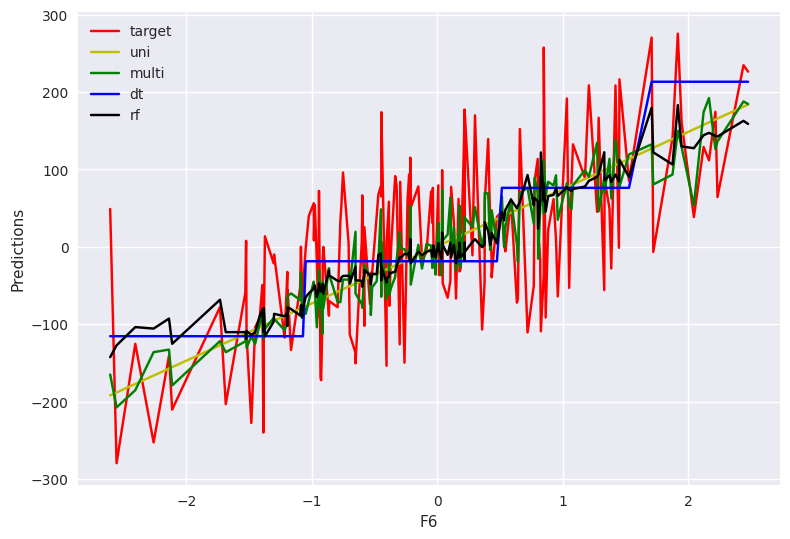

In [292]:
for y_pred, name, color in zip(
    [y_test, y_pred_uni, y_pred_multi, y_pred_dt, y_pred_rf],
    ["target", "uni", "multi", "dt", "rf"],
    ["r", "y", "g", "b", "k"],
):
    df2 = pd.DataFrame(X_test[["F6"]].assign(name=y_pred).sort_values("F6"))
    plt.plot(df2["F6"], df2["name"], color, label=name)


plt.legend(loc="upper left")
plt.xlabel("F6")
plt.ylabel("Predictions")
plt.tight_layout()
plt.style.use("seaborn-v0_8")
plt.show()

## Final observations
### Linear regression
The multivariate regression with all the predicting variables available with respect to the univariate regression has 
- lower RMSE 
- higher coefficient of determination 

### Decision Tree and Random Forest regression
- Decision Tree and Random Forest have an RMSE slightly higher than multivariate linear regression



## Control questions
1. observing the multi-variate experiment, what variable has the higher effect on the target?
1. is there a variable having an almost negligible effect on the target?
1. try to repeat the univariate experiment with other columns and comment the results